### Movie Recommendation System

# Index
- Exploratory Data Analysis(EDA)
- Content based filtering
- Collaborative Filtering
    - Memory based collaborative filtering
        - User-Item Filtering
        - Item-Item Filtering
    - Model based collaborative filtering
        - Single Value Decomposition(SVD)
- Evaluating Collaborative Filtering using SVD
- Hybrid Model

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from surprise.model_selection import cross_validate
from surprise import Reader, Dataset, SVD
from os import path
import warnings; warnings.simplefilter('ignore')

In [2]:
md = pd. read_csv('../data/movies_metadata.csv')
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
links_small = pd.read_csv('../data/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [4]:
md = md.drop([19730, 29503, 35587])

In [5]:
md['id'] = md['id'].astype('int')

In [6]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9099, 24)

We have **9099** movies avaiable in our small movies metadata dataset which is 5 times smaller than our original dataset of 45000 movies.

In [7]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

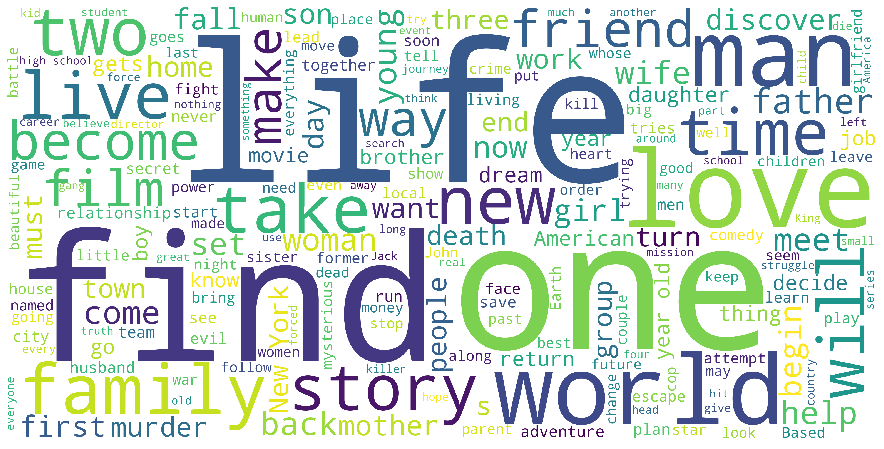

In [8]:
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the movie titles
#smd['description'] = smd['description'].fillna("").astype('str')
plot_corpus = ' '.join(smd['description'])
plot_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(plot_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(plot_wordcloud)
plt.axis('off')
plt.show()

These are most commons words present across the description features of all movies which is a combination of plot overview and movie taglines.

In [9]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

#### Cosine Similarity


In [10]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

We now have a pairwise cosine similarity matrix for all the movies in our dataset. The next step is to write a function that returns the 30 most similar movies based on the cosine similarity score.

In [11]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [12]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [13]:
get_recommendations('The Godfather').head(10)

973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
Name: title, dtype: object

In [14]:
get_recommendations('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

So, we see that it recommends movies which have the word Batman in them and also have similar plots or taglines. Mostly, it is unable to capture other important user profiling data which our next recommender will be able to like genre, cast, crew, keywords etc.

### Metadata Based Recommender


In [15]:
credits = pd.read_csv('../data/credits.csv')
keywords = pd.read_csv('../data/keywords.csv')

In [16]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')

In [17]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [18]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9219, 27)

In [19]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [20]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [21]:
smd['director'] = smd['crew'].apply(get_director)

In [22]:
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [23]:
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [24]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [25]:
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x])

In [26]:
smd['genres'] = smd['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [27]:
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [28]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [29]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [30]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

We will reuse the get_recommendations function that we had written earlier. Since our cosine similarity scores have changed, we expect it to give us different (and probably better) results. Let us check for **The Dark Knight** again and see what recommendations I get this time around.

In [31]:
get_recommendations('The Dark Knight').head(10)

6218                 Batman Begins
8031         The Dark Knight Rises
7659    Batman: Under the Red Hood
1260                Batman & Robin
1134                Batman Returns
524                         Batman
2131                      Superman
132                 Batman Forever
8467                    Kick-Ass 2
8001              Batman: Year One
Name: title, dtype: object

I am much more satisfied with the results I get this time around. The recommendations seem to have recognized other Christopher Nolan movies (due to the high weightage given to director) and put them as top recommendations. I enjoyed watching **The Dark Knight** as well as some of the other ones in the list including **Batman Begins**, **The Prestige** and **The Dark Knight Rises**. 

We can of course experiment on this engine by trying out different weights for our features (directors, actors, genres), limiting the number of keywords that can be used in the soup, weighing genres based on their frequency, only showing movies with the same languages, etc.

Now, we will try to introduce a **popularity filter**. This will ensure that only movies which have a certain number of threshold ratings or votes will be considered so that movies which are not popular enough or not well received are not considered.

In [32]:
vote_counts = smd[smd['vote_count'].notnull()]['vote_count'].astype('int')
m = vote_counts.quantile(0.60)
vote_averages = smd[smd['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [33]:
smd['year'] = pd.to_datetime(smd['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [34]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [35]:
improved_recommendations('The Dark Knight')

,title,vote_count,vote_average,year,wr
8031,The Dark Knight Rises,9263,7,2012,6.982188
6218,Batman Begins,7511,7,2005,6.978117
7583,Kick-Ass,4747,7,2010,6.965776
524,Batman,2145,7,1989,6.927042
8419,Man of Steel,6462,6,2013,5.997925
8467,Kick-Ass 2,2275,6,2013,5.994347
1134,Batman Returns,1706,6,1992,5.992618
132,Batman Forever,1529,5,1995,5.083344
9024,Batman v Superman: Dawn of Justice,7189,5,2016,5.019102
1260,Batman & Robin,1447,4,1997,4.183803


In [36]:
improved_recommendations('Pulp Fiction')

,title,vote_count,vote_average,year,wr
8905,The Hateful Eight,4405,7,2015,6.963209
5200,Kill Bill: Vol. 2,4061,7,2004,6.960206
3771,Training Day,1665,7,2001,6.907789
1381,Jackie Brown,1580,7,1997,6.903269
8110,The Raid,1076,7,2011,6.863633
1532,The French Connection,435,7,1971,6.715227
3249,Traffic,573,6,2000,5.981113
3012,Shaft,316,5,2000,5.298444
4764,S.W.A.T.,780,5,2003,5.150181
7104,The Spirit,323,4,2008,4.616916


Unfortunately, **Batman and Robin** does not disappear from our recommendation list. This is probably due to the fact that it is rated a 4, which is only slightly below average on TMDB. It certainly doesn't deserve a 4 when amazing movies like **The Dark Knight Rises** has only a 7. However, there is nothing much we can do about this. Therefore, we will conclude our Content Based Recommender section here and come back to it when we build a hybrid engine.

## Collaborative Filtering and Evaluation


In [37]:
reader = Reader()

In [38]:
ratings = pd.read_csv('../data/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


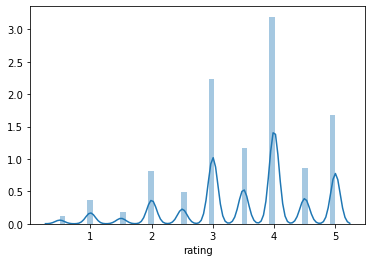

In [39]:
sns.distplot(ratings["rating"]);

It seems users are quite generous in their ratins as a lot of ratings tend to be around 3-4.

In [40]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [41]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8994  0.8958  0.8824  0.9030  0.8988  0.8959  0.0071  
MAE (testset)     0.6941  0.6881  0.6821  0.6941  0.6918  0.6900  0.0045  
Fit time          3.71    3.73    3.79    3.71    3.74    3.74    0.03    
Test time         0.12    0.20    0.13    0.12    0.12    0.14    0.03    


{'test_rmse': array([0.89943473, 0.89583494, 0.88240522, 0.90300603, 0.89884025]),
 'test_mae': array([0.69413021, 0.68813102, 0.68208805, 0.69408966, 0.69177611]),
 'fit_time': (3.712967872619629,
  3.725081443786621,
  3.7856199741363525,
  3.7145798206329346,
  3.737285852432251),
 'test_time': (0.12497067451477051,
  0.2022402286529541,
  0.12511086463928223,
  0.12295794486999512,
  0.12182259559631348)}

##### We get a mean **Root Mean Sqaure Error** of 0.8973.

Let us pick user 1 and check the ratings he/she has given.

In [42]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [43]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.6909391385602386, details={'was_impossible': False})

For movie with ID 302, we get an estimated prediction of **2.743**. One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

## Hybrid Recommender


* **Input:** User ID and the Title of a Movie
* **Output:** Similar movies sorted on the basis of expected ratings by that particular user.

In [44]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [45]:
id_map = pd.read_csv('../data/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')

In [46]:
indices_map = id_map.set_index('id')

In [47]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    
    # consider only movies which are popular enough
    movies = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [48]:
hybrid(1, 'The Dark Knight')

,title,vote_count,vote_average,year,id,est
1031,M,465.0,8.0,1931,832,3.410948
6218,Batman Begins,7511.0,7.5,2005,272,3.041192
2599,Batman: Mask of the Phantasm,218.0,7.4,1993,14919,3.029768
8031,The Dark Knight Rises,9263.0,7.6,2012,49026,2.880259
7583,Kick-Ass,4747.0,7.1,2010,23483,2.866248
8927,Kidnapping Mr. Heineken,193.0,5.8,2015,228968,2.865226
7659,Batman: Under the Red Hood,459.0,7.6,2010,40662,2.858757
8001,Batman: Year One,255.0,7.1,2011,69735,2.718527
9010,Black Mass,1262.0,6.3,2015,261023,2.692346
524,Batman,2145.0,7.0,1989,268,2.633396


In [49]:
hybrid(500, 'The Dark Knight')

,title,vote_count,vote_average,year,id,est
1031,M,465.0,8.0,1931,832,3.691357
7659,Batman: Under the Red Hood,459.0,7.6,2010,40662,3.409011
8031,The Dark Knight Rises,9263.0,7.6,2012,49026,3.320328
9010,Black Mass,1262.0,6.3,2015,261023,3.223611
2599,Batman: Mask of the Phantasm,218.0,7.4,1993,14919,3.139836
8001,Batman: Year One,255.0,7.1,2011,69735,3.126737
8467,Kick-Ass 2,2275.0,6.3,2013,59859,3.044245
6218,Batman Begins,7511.0,7.5,2005,272,2.972535
524,Batman,2145.0,7.0,1989,268,2.952805
7583,Kick-Ass,4747.0,7.1,2010,23483,2.719810


So, we see that the hybrid recommender first takes in the movies outputted by the metadata based recommender and then adds on the estimated rating given by the collaborative filter and sorts them in order of these ratings. This works better in the long run as even if enough user behaviour data is not available then the metadata based recommender can give decent recommendatons. A subtle popularity filter is also introduced here by the metadata based recommender as we saw earlier which only allows movies which have a certain fixed number of ratings to be considered popular enough.